Wczytywanie obrazu indeksu

In [54]:
import math
from statistics import mean

import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.mixture import GaussianMixture

img = cv2.imread("../data/test/numbers2.jpg", 0)
ret, bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

im_height, im_width = bw.shape

Dzielenie indeksu na osobne obrazy-cyfry oraz przycinanie boków tych obrazów

In [55]:
# digits = []
# col = 0
# while col < im_width:
#     if not all(px == 0 for px in bw[:, col]):
#
#         start_index = col
#         while not all(px == 0 for px in bw[:, col]) :
#             col += 1
#         end_index = col - 1
#
#         digits.append(bw[0:im_height, start_index:end_index])
#     col += 1

Przycinanie obrazów cyfr z góry i z dołu

In [56]:
# for i in range(len(digits)):
#     d = digits[i]
#
#     row = 0
#     while all(px == 0 for px in d[row]):
#         row += 1
#     start_index = row
#
#     row = d.shape[0] - 1
#     while all(px == 0 for px in d[row]):
#         row -= 1
#     end_index = row + 1
#
#     digits[i] = d[start_index:end_index, 0:d.shape[0]]

Przycinanie cyfr dbscanem

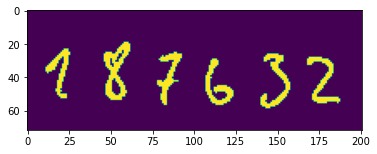

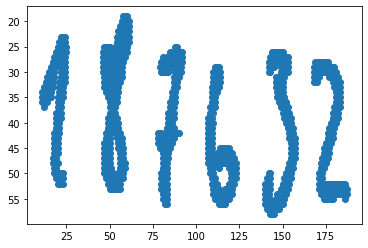

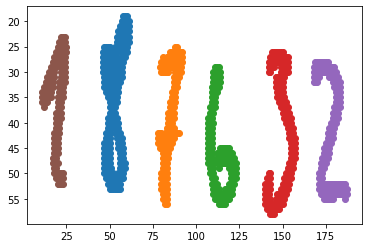

Groups count: 6
Min points in group: 158
Mean points in group: 192.16666666666666


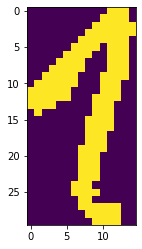

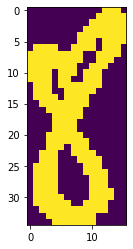

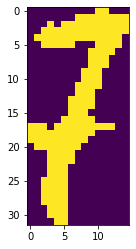

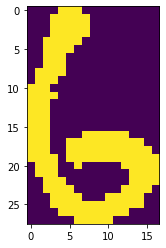

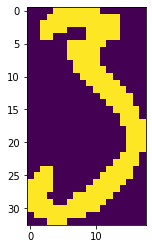

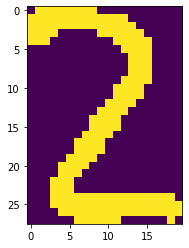

In [57]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, OPTICS

plt.imshow(bw)
plt.show()

non_zero_y, non_zero_x = np.where(bw > 0)
non_zero_points = np.array(list(zip(non_zero_x, non_zero_y)))

plt.scatter(non_zero_points[:, 0], non_zero_points[:, 1])
plt.gca().invert_yaxis()
plt.show()

digits_coord = []
groups = []
# clt = DBSCAN(min_samples=30, eps=5, n_jobs=-1)
# clt = AgglomerativeClustering(n_clusters=None, distance_threshold=300)
clt = OPTICS(min_samples=30, eps=10, min_cluster_size=100, cluster_method='dbscan')
clt.fit(non_zero_points)

for label in np.unique(clt.labels_):
    if label == -1:  # W grupie -1 są outliery
        continue

    points = non_zero_points[np.where(clt.labels_ == label)]
    plt.scatter(points[:, 0], points[:, 1])
    digits_coord.append((min(points[:, 1]), max(points[:, 1] + 1), min(points[:, 0]), max(points[:, 0]) + 1))

    groups.append(points)
plt.gca().invert_yaxis()
plt.show()

print("Groups count:", len(groups))
print("Min points in group:", min(g.shape[0] for g in groups))
print("Mean points in group:", mean(g.shape[0] for g in groups))

# biggest_group = max(digits_coord, key=lambda x: abs(x[0] - x[1]) * abs(x[2] - x[3]))

digits_coord.sort(key=lambda x: x[2])

digits = []
for d in digits_coord:
    digits.append(bw[d[0]:d[1], d[2]:d[3]])

for d in digits:
    plt.imshow(d)
    plt.show()


Upodobnienie obrazów cyfr do obrazów z klasyfikatora mnist (skalowanie oraz dodanie czarnego obramowania)

In [58]:
from cv2 import resize, INTER_AREA, copyMakeBorder, BORDER_CONSTANT, dilate

for i in range(len(digits)):
    d = digits[i]

    d_height, d_width = d.shape

    sample_size = 28
    border_size = 4
    max_size = sample_size - (border_size * 2)

    if d_width > d_height:
        d_proportion = d_height / d_width
        d = resize(d, (max_size, int(max_size * d_proportion)), interpolation=INTER_AREA)
    else:

        d_proportion = d_width / d_height
        d = resize(d, (int(max_size * d_proportion), max_size), interpolation=INTER_AREA)

    border_v = (sample_size - d.shape[0]) / 2
    border_v_T = math.ceil(border_v)
    border_v_B = math.floor(border_v)

    border_h = (sample_size - d.shape[1]) / 2
    border_h_L = math.ceil(border_h)
    border_h_R = math.floor(border_h)

    d = copyMakeBorder(d, border_v_T, border_v_B, border_h_L, border_h_R, BORDER_CONSTANT)

    kernel = np.ones((2, 2), np.uint8)
    d = dilate(d, kernel, iterations=1)

    digits[i] = d

Uczenie klasyfikatora SVM na zbiorze danych mnist (lub wczytanie go z pliku)

In [59]:
import os
import pickle
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC

dataset_pickle_path = "../pickled_objects/dataset_mnist.pickle"
clf_pickle_path = "../pickled_objects/clf_mnist.pickle"

if not os.path.isfile(dataset_pickle_path):
    X, y = data = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    with open(dataset_pickle_path, 'wb') as f:
        pickle.dump(data, f)
else:
    with open(dataset_pickle_path, 'rb') as f:
        X, y = pickle.load(f)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

if not os.path.isfile(clf_pickle_path):
    clf = SVC()
    clf.fit(X, y)
    with open(clf_pickle_path, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(clf_pickle_path, 'rb') as f:
        clf = pickle.load(f)

# y_pred = clf.predict(X_test)
# print(accuracy_score(y_test, y_pred))

Podgląd przetworzonych cyfr oraz cyfr ze zbioru mnist

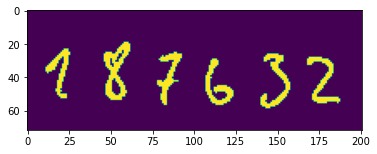

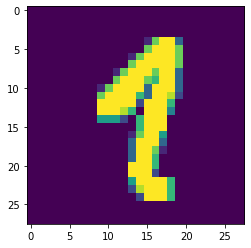

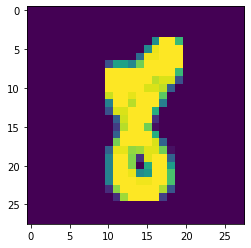

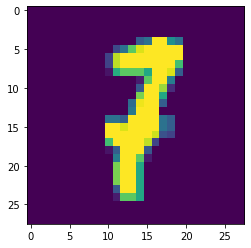

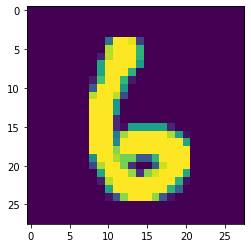

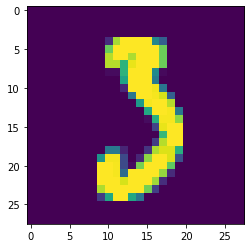

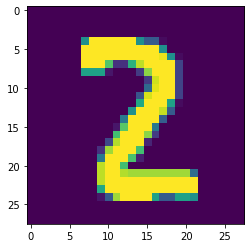

['9' '8' '7' '6' '3' '2']


In [60]:
plt.imshow(bw)
plt.show()

for d in digits:
    plt.imshow(d)
    plt.show()

#
# for i in range(10):
#     plt.imshow(X[i].reshape(28,28))
#     plt.show()

reshaped = np.array([d.reshape(784) for d in digits])
print(clf.predict(reshaped))